# Libraries Import

In [20]:
import numpy as np
import pandas as pd
import warnings
import pickle
import torch
import os
import sys
print("Torch version:", torch.__version__)

# ------- Model
from pytorch_forecasting.models.temporal_fusion_transformer import TemporalFusionTransformer
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder, GroupNormalizer

# ------- Model Metrics
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.metrics import RMSE
from torch.nn import MSELoss

# ------- Model Monitoring
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

# ------- Model Utils
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from torch.utils.data import Dataset, DataLoader

# Data Loader
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "Sources")))
# 📥 Import load fonction
from data_loader import load_data


Torch version: 2.6.0


# I. Data Loading

### I.1. Original Data

In [32]:
# Load Data from CSV to DataFrame
GMM_Data_O = load_data('cluster', 'Copper_Data_GMM_O.csv')
GMM_Data_O.head(2)

✅ Load File : /Users/juniormukenze/Documents/00 Personal Research Publication/Research Paper 1/Enhancing Time Series Forecasting with VAE-based Data Augmentation and Temporal Pattern Analysis using Neural Networks/Modules/data/cluster/Copper_Data_GMM_O.csv  |  Separator detected: ','


,Open,High,Low,Close,group_id,year,month,day,weekday,Cluster_Label
0,0.375645,0.334328,0.362572,0.325786,0,2013,3,25,0,1
1,0.324968,0.304504,0.342561,0.325786,0,2013,3,27,2,1


In [34]:
GMM_Data_O['Cluster_Label'].unique()

array([1, 2, 0])

In [36]:
for col in ['year', 'month', 'day', 'weekday']:
    GMM_Data_O[col] = GMM_Data_O[col].astype(int)

# Construction de la colonne concaténée : YYYYMMDDW
GMM_Data_O['Date_from_start'] = (
    GMM_Data_O['year'].astype(str).str.zfill(4) +
    GMM_Data_O['month'].astype(str).str.zfill(2) +
    GMM_Data_O['day'].astype(str).str.zfill(2) +
    GMM_Data_O['weekday'].astype(str)
).astype(int)

# ⚠️ Conversion explicite de la colonne catégorielle en string
GMM_Data_O["Cluster_Label"] = GMM_Data_O["Cluster_Label"].astype(str)
GMM_Data_O.columns

Index(['Open', 'High', 'Low', 'Close', 'group_id', 'year', 'month', 'day',
       'weekday', 'Cluster_Label', 'Date_from_start'],
      dtype='object')

In [38]:
GMM_Data_O.head(3)

,Open,High,Low,Close,group_id,year,month,day,weekday,Cluster_Label,Date_from_start
0,0.375645,0.334328,0.362572,0.325786,0,2013,3,25,0,1,201303250
1,0.324968,0.304504,0.342561,0.325786,0,2013,3,27,2,1,201303272
2,0.344676,0.303117,0.310401,0.269478,0,2013,3,28,3,1,201303283


### Split Train and Test

In [41]:
DFoGMM = GMM_Data_O.copy()

#Calcul de l’indice de coupure
split_index1 = int(len(DFoGMM) * 0.8)

# 4. Division train/test
DFoGMM_Train = DFoGMM.iloc[:split_index1]
DFoGMM_Test = DFoGMM.iloc[split_index1:]

DFoGMM_Train.shape, DFoGMM_Test.shape

((2267, 11), (567, 11))

In [43]:
DFoGMM_Train['Cluster_Label'].unique()

array(['1', '2', '0'], dtype=object)

### I.2. Augmented Data

In [47]:
# Load Data from CSV to DataFrame
GMM_Data_Aug = load_data('cluster', 'Copper_Data_GMMix.csv')
GMM_Data_Aug.head(2)

✅ Load File : /Users/juniormukenze/Documents/00 Personal Research Publication/Research Paper 1/Enhancing Time Series Forecasting with VAE-based Data Augmentation and Temporal Pattern Analysis using Neural Networks/Modules/data/cluster/Copper_Data_GMMix.csv  |  Separator detected: ','


,Open,High,Low,Close,group_id,year,month,day,weekday,Cluster_Label
0,0.393996,0.350258,0.380149,0.340854,0,2013,3,25,0,0
1,0.340330,0.318698,0.358946,0.340854,0,2013,3,27,2,0


In [49]:
GMM_Data_Aug.head(3)

,Open,High,Low,Close,group_id,year,month,day,weekday,Cluster_Label
0,0.393996,0.350258,0.380149,0.340854,0,2013,3,25,0,0
1,0.340330,0.318698,0.358946,0.340854,0,2013,3,27,2,0
2,0.361200,0.317230,0.324869,0.281214,0,2013,3,28,3,0


In [51]:
GMM_Data_Aug['Cluster_Label'].unique()

array([0, 1, 2])

In [53]:
for col in ['year', 'month', 'day', 'weekday']:
    GMM_Data_Aug[col] = GMM_Data_Aug[col].astype(int)

# Construction de la colonne concaténée : YYYYMMDDW
GMM_Data_Aug['Date_from_start'] = (
    GMM_Data_Aug['year'].astype(str).str.zfill(4) +
    GMM_Data_Aug['month'].astype(str).str.zfill(2) +
    GMM_Data_Aug['day'].astype(str).str.zfill(2) +
    GMM_Data_Aug['weekday'].astype(str)
).astype(int)

# ⚠️ Conversion explicite de la colonne catégorielle en string
GMM_Data_Aug["Cluster_Label"] = GMM_Data_Aug["Cluster_Label"].astype(str)
GMM_Data_Aug.columns

Index(['Open', 'High', 'Low', 'Close', 'group_id', 'year', 'month', 'day',
       'weekday', 'Cluster_Label', 'Date_from_start'],
      dtype='object')

In [55]:
GMM_Data_Aug.head(3)

,Open,High,Low,Close,group_id,year,month,day,weekday,Cluster_Label,Date_from_start
0,0.393996,0.350258,0.380149,0.340854,0,2013,3,25,0,0,201303250
1,0.340330,0.318698,0.358946,0.340854,0,2013,3,27,2,0,201303272
2,0.361200,0.317230,0.324869,0.281214,0,2013,3,28,3,0,201303283


### Split Train and Test

In [58]:
DFaugGMM = GMM_Data_Aug.copy()

#Calcul de l’indice de coupure
split_index2 = int(len(DFaugGMM) * 0.8)

# 4. Division train/test
DFaugGMM_Train = DFaugGMM.iloc[:split_index2]
DFaugGMM_Test = DFaugGMM.iloc[split_index2:]

DFaugGMM_Train.shape, DFaugGMM_Test.shape

((4534, 11), (1134, 11))

In [60]:
DFaugGMM_Train['Cluster_Label'].unique()

array(['0', '1', '2'], dtype=object)

## I.3. Définition du TimeSeriesDataSet

##### Hyperparameters

In [64]:
batch_size = 64
num_heads = 4
hidden_size = 160
learning_rate = 0.001
gradient_clip_val = 0.1

max_prediction_length = 30
max_encoder_length = 90

In [66]:
training_cutoff = DFaugGMM_Train["Date_from_start"].max() - max_prediction_length

training_combined = TimeSeriesDataSet(
    DFaugGMM_Train[lambda x: x.Date_from_start <= training_cutoff],
    time_idx="Date_from_start",
    target="Close",
    group_ids=["group_id"],  # Identification des deux sources
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["Cluster_Label"],
    time_varying_known_reals=["Open", "High", "Low","year", "month", "day", "weekday",], 

    #time_varying_unknown_reals=[],
    target_normalizer=GroupNormalizer(method="robust"),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,  # Gestion des données manquantes
    
)

# Création du DataLoader pour l'entraînement et validation
validation_combined = TimeSeriesDataSet.from_dataset(training_combined, DFaugGMM_Train, predict=True, stop_randomization=True)
test_combined = TimeSeriesDataSet.from_dataset(training_combined, DFaugGMM_Test, predict=True, stop_randomization=True)

train_dataloader_combined = training_combined.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader_combined = validation_combined.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)
test_dataloader_combined = test_combined.to_dataloader(train=False, batch_size=batch_size , num_workers=0)

print("DataLoaders pour deux Inputs prêts ✅")

DataLoaders pour deux Inputs prêts ✅


## I.2. Model Architecture

##### Définition des Callbacks et du Trainer

In [70]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, verbose=True, mode="min")
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger("lightning_logs")

trainer = pl.Trainer(
    max_epochs=45,
    accelerator="gpu",
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=gradient_clip_val,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


##### Définition du Modèle TFT

In [73]:
tft = TemporalFusionTransformer.from_dataset(
    training_combined,
    learning_rate=learning_rate,
    hidden_size=hidden_size,
    attention_head_size=num_heads,
    dropout=0.1,
    hidden_continuous_size=hidden_size,
    output_size=3,  # Une seule sortie (Close)
    loss=QuantileLoss(quantiles=[0.1, 0.5, 0.9]),
    log_interval=10,
    optimizer="ranger",
    reduce_on_plateau_patience=4,
)


/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


##### Entraînement du modèle

In [76]:
trainer.fit(tft, train_dataloader_combined, val_dataloader_combined)


   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 9      | train
3  | prescalers                         | ModuleDict                      | 3.5 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 313 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 841 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 841 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 103 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 103 K  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.298


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.153 >= min_delta = 0.0001. New best score: 0.145


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.097 >= min_delta = 0.0001. New best score: 0.048


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.044


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0001. New best score: 0.036


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.033


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.030


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.029


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.028


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.024


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.022


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.020


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.019


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.017


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.017. Signaling Trainer to stop.


### Model Training Saved

In [78]:
# Model Saved
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)


lightning_logs/lightning_logs/version_0/checkpoints/epoch=33-step=2822.ckpt


In [79]:
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

#zip and download the model
!zip  -r model.zip lightning_logs/lightning_logs_1/version_0/*

/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


zsh:1: no matches found: lightning_logs/lightning_logs_1/version_0/*


In [80]:
# Évaluation sur les données de validation
val_evaluation_dataloader = val_dataloader_combined

actuals = torch.cat([y[0] for x, y in iter(val_evaluation_dataloader)]).to("mps")
predictions = best_tft.predict(val_evaluation_dataloader)

# Calcul de la perte moyenne (p50)
print((actuals - predictions).abs().nanmean().item())

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


0.02944553643465042


### Prediction with Test

In [82]:
raw_predictions = best_tft.predict(test_dataloader_combined, mode="raw", return_x=True)
print(raw_predictions._fields)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


('output', 'x', 'index', 'decoder_lengths', 'y')


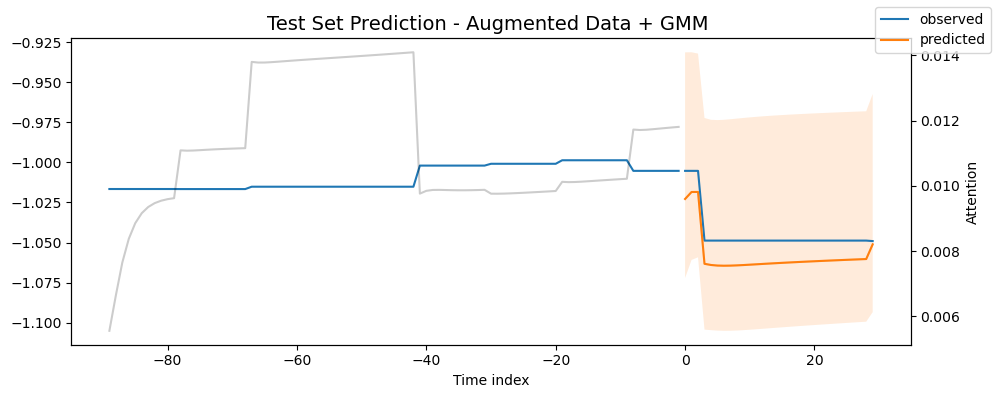

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Générer des prédictions
#raw_predictions, x = tft.predict(val_dataloader_combined, mode="raw", return_x=True)

for idx in range(1):  # plot all 5 consumers
    fig, ax = plt.subplots(figsize=(10, 4))
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=RMSE(),ax=ax)
    ax.set_title(f"Test Set Prediction - Augmented Data + GMM ", fontsize=14)

In [90]:
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Fonction de mMAPE robuste (évite division par zéro)
def modified_mape(y_true, y_pred, epsilon=1e-8):
    return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + epsilon))) * 100

# Récupération des valeurs réelles (y_true) et prédites (y_pred)
val_evaluation_dataloader = val_dataloader_combined

# Prédictions avec le meilleur modèle TFT
actuals = torch.cat([y[0] for x, y in iter(val_evaluation_dataloader)]).cpu().numpy().flatten()
predictions = best_tft.predict(val_evaluation_dataloader).cpu().numpy().flatten()

# Calcul des métriques
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actuals, predictions)
mmape = modified_mape(actuals, predictions)
r2 = r2_score(actuals, predictions)

# Affichage
print(f"✅ Mean Squared Error (MSE)      : {mse:.4f}")
print(f"✅ Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"✅ Mean Absolute Error (MAE)     : {mae:.4f}")
print(f"✅ Modified MAPE (mMAPE)         : {mmape:.2f}%")
print(f"✅ R2 Score                      : {r2:.4f}")


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


✅ Mean Squared Error (MSE)      : 0.0019
✅ Root Mean Squared Error (RMSE): 0.0433
✅ Mean Absolute Error (MAE)     : 0.0294
✅ Modified MAPE (mMAPE)         : 3.16%
✅ R2 Score                      : 0.9977


{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x300 with 1 Axes>,
 'encoder_variables': <Figure size 700x400 with 1 Axes>,
 'decoder_variables': <Figure size 700x400 with 1 Axes>}

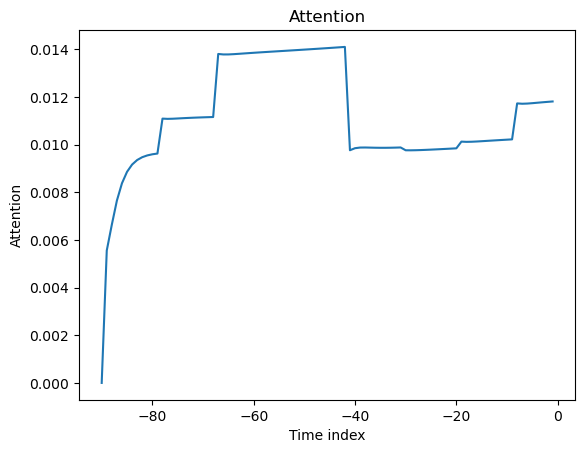

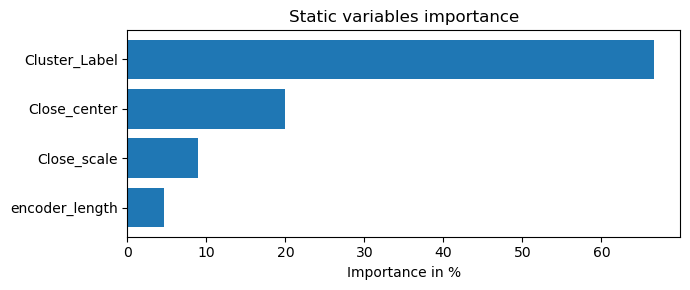

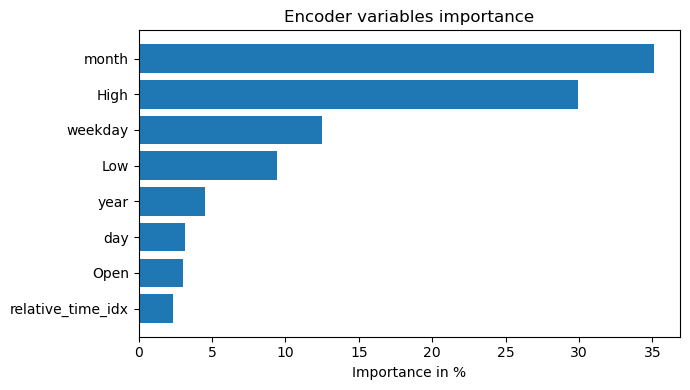

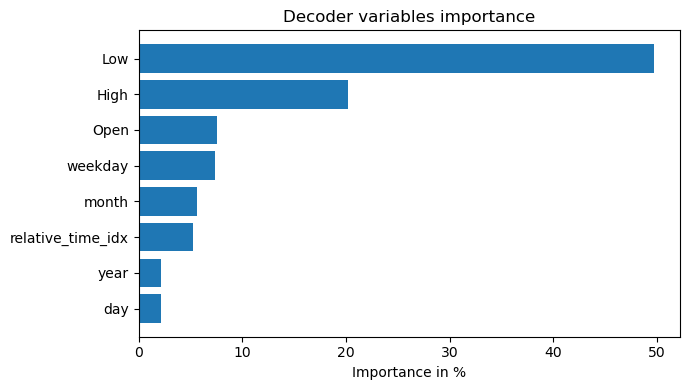

In [86]:
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)